# Исследование воронки продаж стартапа по продаже продуктов питания

***Описание и цели проекта***

Для целей анализа воронки продаж стратапа по продаже продуктов питания и последующего исследования результатов A/A/B-эксперимента для оценки эффекта от изменения шрифтов в приложении изучим следующие имеющиеся в распоряжении данные лога:

- название события
- уникальный идентификатор пользователя
- время события
- номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная

На основаниии указанных данных:

1. Выполним предобработку данных
2. Изучим данные лога: 
- количество пользователей и событий, среднее количество событий на одного пользователя
- оценим и скорректируем при необходимости период, за который анализируются данные
3. Изучим воронку событий:
- построим воронку событий, скорректировав при необходимости перечень рассматриваемых событий
- оценим "потери" пользователей на каждом шаге и в периоде до оплаты
4. В ходе A/A/B-эксперимента оценим влияние изменения шрифтов на долю пользователей на каждом шаге воронки продаж

## Предобработка данных

In [57]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import math as mth
from scipy import stats as st
import plotly.express as px

In [58]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep = '\t')

In [59]:
# Выведем основную информацию о датафрейме
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [60]:
# Переименуем столбцы
data = data.rename(columns = {'EventName': 'event_name', 'DeviceIDHash': 'user_id', 'EventTimestamp': 'event_timestamp', 'ExpId': 'exp_id'}) 

In [61]:
# Проверим количество дубликатов
f'Количество дубликатов: {data.duplicated().sum()}'

'Количество дубликатов: 413'

In [62]:
# Выведем уникальные названия групп и этапов воронки, чтобы проверить наличие неявных дубликатов 
print(f' Уникальные значения в столбце с названиями событий: {data["event_name"].unique()}')
f' Уникальные значения в столбце с названиями групп: {data["exp_id"].unique()}'

 Уникальные значения в столбце с названиями событий: ['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']


' Уникальные значения в столбце с названиями групп: [246 248 247]'

Неявные дубликаты отсутствуют

In [63]:
# Удалим дубликаты и проверим результат удаления
data = data.drop_duplicates()
f'Количество дубликатов: {data.duplicated().sum()}'

'Количество дубликатов: 0'

In [64]:
# Проверим наличие пропусков в данных
f'Количество пропусков: {data.isna().sum().sort_values(ascending = False)}'

'Количество пропусков: event_name         0\nuser_id            0\nevent_timestamp    0\nexp_id             0\ndtype: int64'

Пропуски отсутствуют

In [65]:
# Исправим формат данных в столбце с датой события
data['event_timestamp'] = pd.to_datetime(data['event_timestamp'], unit = 's') 

# Также изменим тип данных в столбце с группой на 'object', т.к. это не число, а категория
data['exp_id'] = data['exp_id'].astype('object')

# Добавим столбец с датой
data['event_date'] = pd.to_datetime(data['event_timestamp']).dt.date
data.head()

,event_name,user_id,event_timestamp,exp_id,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


## Предварительный анализ данных

In [66]:
# Определим, сколько всего событий в логе
# Поскольку датафрейм очищен от пропусков и дубликатов, количество строк должно быть равно количеству уникальных событий
f'Количество событий в логе: {len(data)}'

'Количество событий в логе: 243713'

In [67]:
# Определим, сколько всего пользователей в логе
f"Количество пользователей в логе: {data['user_id'].nunique()}"

'Количество пользователей в логе: 7551'

In [68]:
# Определим, сколько в среднем событий приходится на пользователя
f"В среднем на одного пользователя приходится {round(len(data)/data['user_id'].nunique(), 2)} событий"

'В среднем на одного пользователя приходится 32.28 событий'

In [69]:
# Оценим разброс количества событий на одного пользователя

data_events_per_users= (data
                        .pivot_table(index = 'user_id', values = 'event_name', aggfunc = 'count')
                        .rename(columns = {'event_name': 'events_number'}) 
                       )
display(data_events_per_users.head())
data_events_per_users['events_number'].describe()

,events_number
user_id,
6888746892508752,1
6909561520679493,5
6922444491712477,47
7435777799948366,6
7702139951469979,137


count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: events_number, dtype: float64

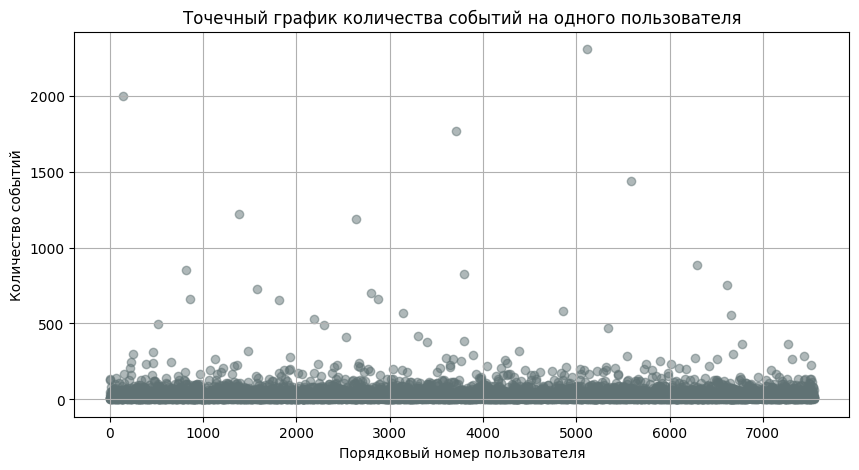

In [70]:
plt.figure(figsize = (10, 5))
x_values = pd.Series(range(0,len(data_events_per_users)))
plt.scatter(x_values, data_events_per_users['events_number'], color = '#607274', alpha = 0.5) 
plt.xlabel('Порядковый номер пользователя')
plt.ylabel('Количество событий')
plt.title('Точечный график количества событий на одного пользователя') 
plt.grid()
plt.show()

Медианное количество событий на одного пользователя - 20, при этом минимальное количество - 1, а максимальное - 2307, 75 % пользователей совершают не более 35 событий. Кроме того, большое количества выбросов также видим на точечном графике. Соответственно, отдельные наиболее активные пользователи из-за аномально большого количества событий, попав в одну из групп, могут повлиять на результат теста при оценке количества событий на каждом этапе, однако удаление каждого из таких пользователей может привести к потере большого числа событий, поэтому будем контролировать объем удаленных данных(событий) первоначального датасета, чтобы потерять не более 5 %.

In [71]:
# Сохраним в переменные размер первоначального датасета(количество событий), а также количество уникальных пользователей, 
# чтобы в дальнейшем использователь для оценки размера удаленных данных
rows_events = data.shape[0] 
rows_users = data['user_id'].nunique()
rows_events, rows_users

(243713, 7551)

In [72]:
dad = data_events_per_users.query('events_number < 1300').index
data = data.query('user_id in @dad')

print(f'Удалено событий: {rows_events - data.shape[0]} шт. ({round(((1 - data.shape[0]/rows_events)*100), 2)} % данных)')  
print(f'Удалено пользователей: {rows_users - data["user_id"].nunique()} шт. ({round(((1 - data["user_id"].nunique()/rows_users)*100), 2)} % данных)') 

Удалено событий: 7512 шт. (3.08 % данных)
Удалено пользователей: 4 шт. (0.05 % данных)


In [73]:
# Оценим временной промежуток, за который предоставлены данные
print(f"Данные за период с {data['event_date'].min()} по {data['event_date'].max()}")

Данные за период с 2019-07-25 по 2019-08-07


Итого в нашем распоряжении данные за 14 дней

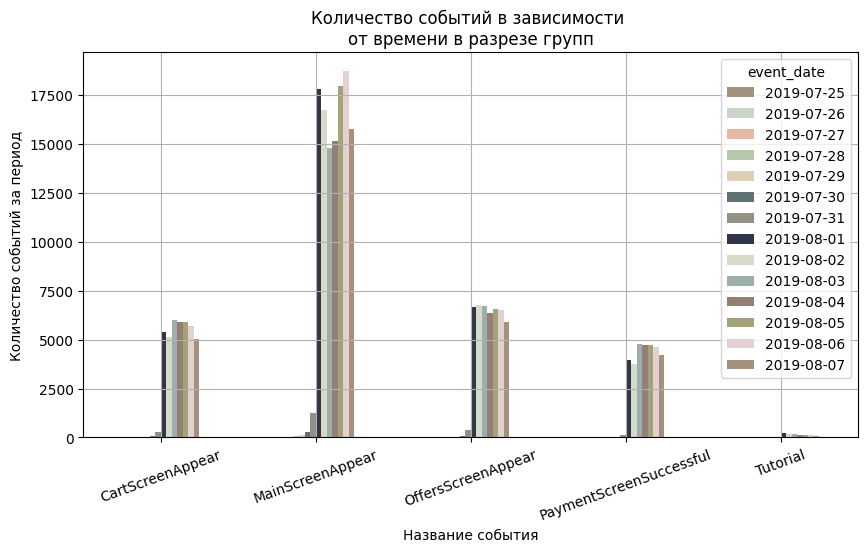

In [74]:
# Определим, как меняется количество данных за рассматриваемый период
data_grouped_by_event = data.pivot_table(index = 'event_name', columns = 'event_date', values = 'user_id', aggfunc = 'count')
data_grouped_by_event.plot(kind = 'bar', figsize = (10, 5), color = ['#A0937D', '#CCD3CA', '#E6B9A6', '#B6C7AA', '#DED0B6', '#607274', '#939185', '#2F3645', '#D6DAC8', '#9CAFAA', '#967E76', '#A2A378', '#E4D0D0', '#A4907C', '#C7BCA1', '#AA8B56'])
plt.xlabel('Название события')
plt.ylabel('Количество событий за период')
plt.title('Количество событий в зависимости \nот времени в разрезе групп') 
plt.xticks(rotation = 20)
plt.grid()
plt.show()

На диаграмме видим, что столбцы, показывающие количество событий за июль (с 25.07.19 по 31.07.19) практически не визуализируются, т.к. данные ха указанный период представлены в гораздо меньшем объеме, чем данные за август (с 01.08.19 по 07.08.19), поэтому для целей исследования имеет смысл ограничить рассматриваемые данные временным промежутком с 01.08.19 по 07.08.19, т.е. периодом в одну неделю.

In [75]:
# Рассмотрим более детально переход с 31 июля на 1 августа
data_3107_0108 = data.query('event_timestamp >= "2019-07-31 00:00:00" and event_timestamp < "2019-08-02 00:00:00"')
data_3107_0108

,event_name,user_id,event_timestamp,exp_id,event_date
797,MainScreenAppear,3670880358399219515,2019-07-31 01:11:46,247,2019-07-31
798,OffersScreenAppear,3799109751993694887,2019-07-31 01:21:04,248,2019-07-31
799,Tutorial,1126021718529336913,2019-07-31 01:32:11,247,2019-07-31
800,MainScreenAppear,4293428370257583636,2019-07-31 02:19:18,248,2019-07-31
801,MainScreenAppear,4567464647598975872,2019-07-31 02:33:30,247,2019-07-31
...,...,...,...,...,...
39031,OffersScreenAppear,6077372516405234625,2019-08-01 23:56:45,246,2019-08-01
39032,OffersScreenAppear,6077372516405234625,2019-08-01 23:56:57,246,2019-08-01
39035,OffersScreenAppear,1872978591788881482,2019-08-01 23:57:31,247,2019-08-01
39041,OffersScreenAppear,6077372516405234625,2019-08-01 23:57:50,246,2019-08-01


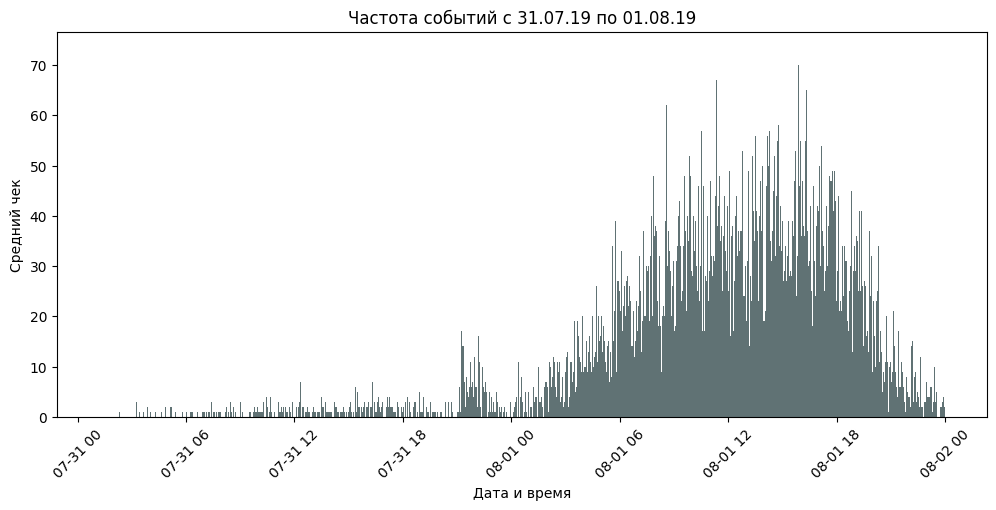

In [76]:
# Визуализируем количество всех событий с 31.07.19 по 01.08.19, 
#указав количество корзин сопоставимое с количеством минут в рассматриваемом промежутке
plt.figure(figsize = (12, 5))
data_3107_0108['event_timestamp'].hist(bins = 2880, grid = True, color =  '#607274')
plt.xlabel('Дата и время')
plt.ylabel('Средний чек')
plt.title('Частота событий с 31.07.19 по 01.08.19') 
plt.xticks(rotation = 45)
plt.grid()
plt.show()

Первый скачок произошел 31.07.после 21:00, далее количество постепенно возрастало c 00:00 01.08

In [77]:
# Ограничим данные временным промежутком с 01.08.19 по 07.08.19 и перезапишем их в новую переменную

data_new = data.query('event_timestamp >= "2019-07-31 21:00:00"')

# Оценим объем удаленных данных
print(f'Удалено событий: {rows_events - data_new.shape[0]} шт. ({round(((1 - data_new.shape[0]/rows_events)*100), 2)} % данных)')  
print(f'Удалено пользователей: {rows_users - data_new["user_id"].nunique()} шт. ({round(((1 - data_new["user_id"].nunique()/rows_users)*100), 2)} % данных)') 

Удалено событий: 9499 шт. (3.9 % данных)
Удалено пользователей: 17 шт. (0.23 % данных)


In [78]:
# Удостоверимся, что в новую переменную записаны данные о всех трех группах пользователей
f"В новом датасете представлены представители следующих экспериментальных групп: {data_new['exp_id'].unique()}"

'В новом датасете представлены представители следующих экспериментальных групп: [247 248 246]'

Представители всех трех групп попали в новый датасет

## Анализ воронки событий

In [79]:
# Проверим частоту появления каждого события в логе
data_new['event_name'].value_counts(ascending = False)

MainScreenAppear           117547
OffersScreenAppear          45702
CartScreenAppear            39117
PaymentScreenSuccessful     30838
Tutorial                     1010
Name: event_name, dtype: int64

Отсортированные по частоте собятия представляют собой воронку, где события представлены в хронологической последовательности: 
- главная страница
- страница с предложениями
- корзина заказа
- оплата заказа

Однако обучение - наиболее редкое событие, вероятно, оно не является обязательным и не встраивается в воронку.

In [80]:
# Определим, сколько уникальных пользователей совершали каждое из этих событий
data_new_pivot_event = (data_new
 .pivot_table(index = 'event_name', values = 'user_id', aggfunc = 'nunique')
 .sort_values(by = 'user_id', ascending = False)
 .rename(columns = {'user_id': 'users_number'})
)
# Посчитаем долю пользователей, которые хоть раз совершали событие
data_new_pivot_event['users_rate_%'] = (data_new_pivot_event['users_number']/data_new['user_id'].nunique()*100).round(2) 
data_new_pivot_event

,users_number,users_rate_%
event_name,,
MainScreenAppear,7419,98.47
OffersScreenAppear,4593,60.96
CartScreenAppear,3732,49.54
PaymentScreenSuccessful,3536,46.93
Tutorial,843,11.19


Количество пользователей  также уменьшается, как и количество самих событий, т.е. некоторые пользователи не дошли до следующего шага вообще. Наиболее значительная потеря пользователей - чуть менее 40% - на этапе перехода с гланого экрана на страницу с предложениями. Кроме того, имеет смысл отказаться от учета обучения, т.к., вероятно, являясь необязательным, оно для нас неинформативно - лишь 11 % всех пользователей его прошли.

In [81]:
# Создадим переменную, содержащую данные без учета событий tutorial
data_funnel = data_new.query('event_name != "Tutorial"')

# Оценим объем удаленных данных
print(f'Удалено событий: {rows_events - data_funnel.shape[0]} шт. ({round(((1 - data_funnel.shape[0]/rows_events)*100), 2)} % данных)')  
print(f'Удалено пользователей: {rows_users - data_funnel["user_id"].nunique()} шт. ({round(((1 - data_funnel["user_id"].nunique()/rows_users)*100), 2)} % данных)') 

Удалено событий: 10509 шт. (4.31 % данных)
Удалено пользователей: 21 шт. (0.28 % данных)


In [82]:
# Определим, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем) 
data_funnel_pivot_events = (data_funnel
 .pivot_table(index = 'event_name', values = 'user_id', aggfunc = 'nunique')
 .sort_values(by = 'user_id', ascending = False)
 .rename(columns = {'user_id': 'users_number'}).reset_index()
)
# Для начала посчитаем более показательный процент потерь пользователей
data_funnel_pivot_events['users_lost_rate, %'] = ((data_funnel_pivot_events['users_number'].pct_change())*100).fillna(0).round(2)

# Дополнительно посчитаем прлоцент сохраненных пользользователей
data_funnel_pivot_events['users_saved_rate, %'] = data_funnel_pivot_events['users_lost_rate, %'] + 100
data_funnel_pivot_events

,event_name,users_number,"users_lost_rate, %","users_saved_rate, %"
0,MainScreenAppear,7419,0.00,100.00
1,OffersScreenAppear,4593,-38.09,61.91
2,CartScreenAppear,3732,-18.75,81.25
3,PaymentScreenSuccessful,3536,-5.25,94.75


In [83]:
# Отобразим воронку графически
funnel_for_graph = dict(values = data_funnel_pivot_events['users_number'], labels = data_funnel_pivot_events['event_name']) 
funnel_graph = px.funnel(funnel_for_graph, y = 'labels', x = 'values', title = 'Воронка событий')
funnel_graph.update_layout(autosize = False, width = 800, height = 450)
funnel_graph.show()

Наибольшее количество пользователей уходит после просмотра главной страницы, не переходя на страницу просмотра товаров - 38 % от всех, кто был на главной странице.

In [84]:
# Определим, какая доля пользователей доходит от просмотра главной страницы до оплаты
f"Доля покупателей прошедших путь от просмотра главного экрана до оплаты: {(data_funnel_pivot_events['users_number'].min()/data_funnel_pivot_events['users_number'].max()*100).round(2)} %"

'Доля покупателей прошедших путь от просмотра главного экрана до оплаты: 47.66 %'

Конверсия пользолвателей в покупателей составляет 47,7 %, т.е. потери составляют более 50 % 

## Результаты эксперимента

In [85]:
# Определим, сколько пользователей в каждой экспериментальной группе
users_per_group = (data_funnel
                   .pivot_table(index = 'exp_id', values = 'user_id', aggfunc = 'nunique')
                   .rename(columns = {'user_id': 'total_users_number'})
                   .reset_index()
                   .T
                  )
# Добавим строку с суммой уникальных пользователей 246 и 247 
#присвоим ей номер 493 - суммы чисел, означаюших две контрольные группы
users_per_group[3] = users_per_group[0] + users_per_group[1]
users_per_group = users_per_group.T
users_per_group

,exp_id,total_users_number
0,246,2482
1,247,2515
2,248,2533
3,493,4997


In [86]:
# Удостоверимся, что в группы 246, 247, 248 не попали одни и те же пользователи, т.е. сумма уникальных пользователей каждой из групп 
# равна общему количеству уникальных пользователей приложения
data_funnel['user_id'].nunique() == users_per_group.query('exp_id in [246, 247, 248]')['total_users_number'].sum()

True

Равенство соблюдается. Число пользователей во всех группах сопоставимо, количество пользователей в группах 246 и 247 для A/A теста отличаются на 1,1 %, что является допустимым уровнем 

In [87]:
# Создадим датафрейм для проведения A/A и A/B тестов
data_for_test = (data_funnel
                            .pivot_table(index = 'event_name', values = 'user_id', columns = 'exp_id', aggfunc = 'nunique')
                            .sort_values(by = [246, 247, 248], ascending = False)
                            .rename(columns = {'user_id': 'users_number'})
                           )
# Добавим  столбец с суммой уникальных пользователей 246 и 247 
#присвоим ей номер 493 - суммы чисел, означаюших две контрольные группы

data_for_test[493] = data_for_test[246] + data_for_test[247]
data_for_test

exp_id,246,247,248,493
event_name,,,,
MainScreenAppear,2449,2478,2492,4927
OffersScreenAppear,1541,1523,1529,3064
CartScreenAppear,1265,1238,1229,2503
PaymentScreenSuccessful,1199,1157,1180,2356


In [88]:
# Зададим функцию, которая будет считать p-value для пар заданных групп на основании датафрейма, созданного для теста
def get_p_value(group_1, group_2):
    data = data_for_test[[group_1, group_2]]
    result = []
    total_users = np.array(users_per_group.query('exp_id == @group_1 or exp_id == @group_2')['total_users_number'])
    for i in range(len(data)): 
        event_users_number = np.array(data)[i]
        p1 = event_users_number[0]/total_users[0]
        p2 = event_users_number[1]/total_users[1]
        p_combined = (event_users_number[0] + event_users_number[1]) / (total_users[0] + total_users[1])
        difference = p1 - p2 
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/total_users[0] + 1/total_users[1]))
        distr = st.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        result.append(p_value)
    return result

Поскольку мы планируем проводить множественные тесты на одних и тех же данных (по 4 теста для черырех пар групп:246 и 247 - А/А тест, 246 и 248 - A/B тест, 247 и 248 - A/B тест, (246 + 247) и 248), необходимо сделать поправку уровня значимости. Для сохранения мощности теста используем метод Холма для 16 тестов. 

In [89]:
# Рассчитаем скорректированный уровень значимости для 16 тестов и создадим объект Series

m, alpha = 16, 0.01
alpha_holm = []
for i in range(m): 
    alpha_holm += [alpha / (m - i)]
alpha_holm

[0.000625,
 0.0006666666666666666,
 0.0007142857142857143,
 0.0007692307692307692,
 0.0008333333333333334,
 0.0009090909090909091,
 0.001,
 0.0011111111111111111,
 0.00125,
 0.0014285714285714286,
 0.0016666666666666668,
 0.002,
 0.0025,
 0.0033333333333333335,
 0.005,
 0.01]

In [90]:
# Создадим цикл, котрый рассчитает p-value по 4 тестам для трех групп 
test_result = []
for pair in [[246, 247], [246, 248], [247, 248], [248, 493]]:
    p_values = get_p_value(pair[0], pair[1])
    test_result.append(p_values)
test_result


[[0.6702236010141238,
  0.26673830926007813,
  0.21809677354098067,
  0.1028498356881653],
 [0.3959763243279397,
  0.21034638141441775,
  0.08307491662576827,
  0.22188599911770135],
 [0.6710440597662208,
  0.8882199810663947,
  0.6163005981950567,
  0.6788717957761099],
 [0.45873239802488186,
  0.4228153650951172,
  0.19780083332974252,
  0.6435931727439441]]

Для всех тестов сформулируем нулевую и альтернативную гипотезы:

- Нулевая гипотеза: между сравниваемыми долями уникальных пользователей групп на каждом этапе воронки от общего количества уникальных пользователей сравниваемых групп нет статистически значимой разницы
- Альтернативная гипотеза: между сравниваемыми долями уникальных пользователей групп на каждом этапе воронки от общего количества уникальных пользователей сравниваемых групп есть статистически значимая разница

In [91]:
test_name = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
test_tables = pd.DataFrame(data = test_result, columns = test_name).T
test_tables.columns = ['test_246_247', 'test_246_248','test_247_248', 'test_248_493']
test_tables
# Добавим столбцы со скорректированным критическим уровнем значимости

test_tables.insert(1, 'alpha_holm_246_247', alpha_holm[0:4])
test_tables.insert(3, 'alpha_holm_246_248', alpha_holm[4:8])
test_tables.insert(5, 'alpha_holm_247_248', alpha_holm[8:12])
test_tables.insert(7, 'alpha_holm_248_493', alpha_holm[12:16])

# Добавим столбцы с результатом проверки гипотез
test_tables.insert(2, 'result_246_247', test_tables['test_246_247'] < test_tables['alpha_holm_246_247'])
test_tables.insert(5, 'result_246_248', test_tables['test_246_248'] < test_tables['alpha_holm_246_248'])
test_tables.insert(8, 'result_247_248', test_tables['test_247_248'] < test_tables['alpha_holm_247_248'])
test_tables.insert(11, 'result_248_493', test_tables['test_248_493'] < test_tables['alpha_holm_248_493'])
test_tables

,test_246_247,alpha_holm_246_247,result_246_247,test_246_248,alpha_holm_246_248,result_246_248,test_247_248,alpha_holm_247_248,result_247_248,test_248_493,alpha_holm_248_493,result_248_493
MainScreenAppear,0.670224,0.000625,False,0.395976,0.000833,False,0.671044,0.001250,False,0.458732,0.002500,False
OffersScreenAppear,0.266738,0.000667,False,0.210346,0.000909,False,0.888220,0.001429,False,0.422815,0.003333,False
CartScreenAppear,0.218097,0.000714,False,0.083075,0.001000,False,0.616301,0.001667,False,0.197801,0.005000,False
PaymentScreenSuccessful,0.102850,0.000769,False,0.221886,0.001111,False,0.678872,0.002000,False,0.643593,0.010000,False


In [92]:
# Создадим датафрейм, который содержит наименования этапов, этап воронки, p-value

test_name = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
test_table = pd.DataFrame(data = test_result, columns = test_name).T
test_table.columns = ['246_247_test', '246_248_test','247_248_test', '248_493_test']

# Добавим необходимые в цикле столбцы со скорректированным критическим уровнем значимости и с результатом проверки гипотез
i = 1
n = 0
for col in test_table.columns:
    test_table.insert(i, f'{col}_alpha_h', alpha_holm[n:n+4])
    test_table.insert(i+1, f'{col}_result', test_table[col] < test_table[f'{col}_alpha_h'])
    i += 3
    n += 4

test_table

,246_247_test,246_247_test_alpha_h,246_247_test_result,246_248_test,246_248_test_alpha_h,246_248_test_result,247_248_test,247_248_test_alpha_h,247_248_test_result,248_493_test,248_493_test_alpha_h,248_493_test_result
MainScreenAppear,0.670224,0.000625,False,0.395976,0.000833,False,0.671044,0.001250,False,0.458732,0.002500,False
OffersScreenAppear,0.266738,0.000667,False,0.210346,0.000909,False,0.888220,0.001429,False,0.422815,0.003333,False
CartScreenAppear,0.218097,0.000714,False,0.083075,0.001000,False,0.616301,0.001667,False,0.197801,0.005000,False
PaymentScreenSuccessful,0.102850,0.000769,False,0.221886,0.001111,False,0.678872,0.002000,False,0.643593,0.010000,False


Набор тестов показал отсутствие статистически значимой разницы в долях пользователей, находящихся на разных этапах воронки - для всех проведенных тестов полученный уровень p-value не позволяет отклонить нулевую гипотезу при принятом критическом уровне статистической значимости с учетом поправки методом Холма.  Для A/A-теста (сравнения двух контрольных групп 246 и 247) это означает отсутствие разницы между выборками, группы разбиты корректно. Для тестов, в ходе которых тестируемая группа поочередно сравнивалась с каждой из контрольных (A/B тест), где статистически значимая разница между группами также не была обнаружена, это означает отсутствие эффекта от проводимых мероприятий, в данном случае - от изменения шрифтов во всем приложении. 

## Выводы

В ходе анализа данных лога мобильного приложения по продаже продуктов питания было обнаружено, что более 50 % пользователей не доходят до этапа отлаты заказа, а наиболее существенные потери пользователей (чуть менее 40%) происходят на этапе перехода с гланого экрана на страницу с предложениями, что может говорить о проблемах, которые возникают у пользователя в ходе взаимодействия с главной страницей.

Анализ результатов эксперимента по изменению шрифтов во всем приложении, в ходе которого были проведены тесты на двух контрольных и одной экспериментальной группе показал отсутствие статистичеки значимого влияния этого изменения на воронку событий - статистически значимая разница в долях пользователей на каждом этапе воронки от общего числа пользователей группы для контрольных (до изменения) и экспериментальной (после изменения) групп отсутствует.